In [1]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [2]:
scen_labels_ = pd.read_csv(path_to_csvs + '/policy_iced-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

In [3]:
# Grab data from databases for plotting LCOE emissions
def _load_cost(scen_labels_):
    # Load fuel, and operation and maintanace cost table and process data from database
    def __load_vr_cost_from_csv(df_, scenario):
        
        df_['variable_om_cost'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['variable_om_cost']
         
        df_ = df_[['period', 'technology', 'load_zone', 'variable_om_cost']]
        df_ = df_.rename(columns = {'variable_om_cost': 'variable_cost'})
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_

    # Load fix capacity cost table and process data from database
    def __load_fx_cost_from_csv(project_, new_, spec_, scenario):
        
        new_ = new_.fillna({'capacity_cost': 0, 'fixed_cost': 0})
        
        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']

        new_ = new_[['period', 'technology', 'load_zone', 'fixed_cost']]
        new_ = new_.groupby(['period', 
                             'technology', 
                             'load_zone']).sum().reset_index(drop = False)
                             
        spec_['fixed_cost'] = spec_['fixed_cost_per_mw_yr'] 

        spec_ = pd.merge(spec_, project_, on = ['project'])
        spec_ = spec_[['period', 'technology', 'load_zone', 'fixed_cost']]
        spec_ = spec_.groupby(['period', 
                               'technology', 
                               'load_zone']).sum().reset_index(drop = False)

        df_ = pd.concat([new_, spec_], axis = 0)
        df_ = df_.groupby(['period', 
                           'technology',
                           'load_zone']).sum().reset_index(drop = False)
        
        df_['scenario'] = scenario    

        return df_

    # Load transmission capacity cost table and process data from database
    def __load_tx_cost_from_csv(project_, new_, scenario):

        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
        new_ = new_[['period', 'transmission_line', 'max_mw', 'fixed_cost']]
        new_ = new_.rename(columns = {'max_mw': 'power_mw'})
        df_  = new_.groupby(['period', 
                             'transmission_line']).sum().reset_index(drop = False)
        project_ = project_.loc[project_['vintage'] == 2020].reset_index(drop = False)
        project_ = project_[['transmission_line', 'tx_annualized_real_cost_per_mw_yr']]
        
#         project_p_                      = project_.copy()
#         project_p_['transmission_line'] = project_p_['transmission_line'].str.replace('_new', '')
#         project_ = pd.concat([project_, project_p_], axis = 0).reset_index(drop = True)

        df_                  = pd.merge(df_, project_, on = ['transmission_line'])
        df_['capacity_cost'] = df_['tx_annualized_real_cost_per_mw_yr']*df_['power_mw']
        df_['load_zone']     = df_['transmission_line'].apply(lambda x: x.split("-")[0])
        df_                  = df_[['period', 'load_zone', 'capacity_cost', 'fixed_cost']]
        df_                  = df_.groupby(['period', 
                                            'load_zone']).agg({'capacity_cost': 'sum', 
                                                               'fixed_cost': 'sum'}).reset_index(drop = False)
        df_['fixed_cost']    = df_['capacity_cost'] + df_['fixed_cost']
        df_['variable_cost'] = 0.
        df_                  = df_[['period', 'load_zone', 'fixed_cost', 'variable_cost']]
        df_['technology']    = 'Tx_Losses'    
        df_['scenario']      = scenario    
        
        return df_

    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 
                           'load_zone']).sum().reset_index(drop = False)
                         
        df_['technology'] = 'Demand'     
        df_['scenario']   = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)
        
        # Load fix costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        spec_    = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_ = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        fx_      = __load_fx_cost_from_csv(project_, new_, spec_, scen)
        
        # Load variables costs from csv files
        vr_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        vr_ = __load_vr_cost_from_csv(vr_, scen)
        
        # Load tx costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False) 
        spec_    = pd.read_csv(dir_name + r'/inputs/specified_transmission_line_capacities.tab', sep = '\t', engine = 'python')        
        project_ = pd.read_csv(dir_name + r'/inputs/new_build_transmission_vintage_costs.tab', sep = '\t', engine = 'python')
        tx_      = __load_tx_cost_from_csv(project_, new_, scen)

        df_ = pd.merge(vr_, fx_, on = ['scenario', 'technology', 'period', 'load_zone'])
        df_ = pd.concat([df_, tx_], axis = 0)

        dfs_1_.append(df_)
        dfs_2_.append(load_)

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)
    
    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)

    return df_1_, df_2_

In [4]:
def _group_tech_cost_by_tech(df_1_, df_2_, scen_labels_):

    columns_ = ['period', 'technology', 'scenario', 'load_zone']
    
    dfs_1_ = []
    dfs_2_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_1_p_ = df_1_.loc[df_1_['scenario'] == scen].copy()
        df_2_p_ = df_2_.loc[df_2_['scenario'] == scen].copy()

        idx_1_ = df_1_p_['load_zone'] == zone
        idx_2_ = df_2_p_['load_zone'] == zone

        if idx_1_.sum() == 0.:
            df_1_p_['load_zone'] = 'all'
            df_2_p_['load_zone'] = 'all'
        else:
            df_1_p_ = df_1_p_.loc[idx_].reset_index(drop = True)
            df_2_p_ = df_2_p_.loc[idx_].reset_index(drop = True)

        dfs_1_.append(df_1_p_.groupby(columns_).sum().reset_index(drop = False))
        dfs_2_.append(df_2_p_.groupby(columns_).sum().reset_index(drop = False))

    df_1_ = pd.concat(dfs_1_, axis = 0).reset_index(drop = True)
    df_2_ = pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

    df_1_['period']        = df_1_['period'].astype(int)
    df_1_['fixed_cost']    = df_1_['fixed_cost'].astype(float)
    df_1_['variable_cost'] = df_1_['variable_cost'].astype(float)

    df_2_['period']  = df_2_['period'].astype(int)
    df_2_['load_mw'] = df_2_['load_mw'].astype(float)
    
    return df_1_, df_2_

def _group_cost_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'variable_cost': 'sum', 
                                         'fixed_cost': 'sum'})

    return df_.reset_index(drop = False)

In [12]:
def _plot_levelized_fixed_and_variable_cost(ax, df_1_, df_2_, scens_label_, tech_label_, 
                                            units        = 1,
                                            units_label  = 'Levelized Technology Costs (USD per MWh)',
                                            y_period_loc = -38,
                                            y_grid_inc   = 10,
                                            div_line_len = 0.49,
                                            legend       = True,
                                            title        = ''):

    def __make_fixed_and_variable_cost_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('Tx_Losses', 'Tx'),
                                       zorder = 10)

    periods_     = np.sort(df_1_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):
        print(scen)

        df_p_ = df_1_.copy()
            
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen)  & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(df_p_, techs_, colors_, ax)
            
            z = df_2_.loc[(df_2_['scenario'] == scen)  & (df_2_['period'] == period), 'load_mw'].to_numpy()[0]

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()
                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom    = offset/units,
                           color     = c,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y/z

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], (y/z)/units, width, 
                           bottom = offset/units,
                           color  = c,
                           zorder = 10)

                    offset += y/z

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                weight              = 'bold',
                                                horizontalalignment = 'center', 
                                                verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 12, 
                             left      = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-.25, 70)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                        y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

def _plot_total_fixed_and_variable_cost(ax, df_, scens_label_, tech_label_, 
                                        units        = 1e9,
                                        units_label  = 'System Costs (Billions USD)',
                                        y_period_loc = -217.5,
                                        y_grid_inc   = 50,
                                        div_line_len = 0.5,
                                        legend       = True,
                                        title        = ''):

    def __make_fixed_and_variable_cost_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Variable Costs',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'fixed_cost'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('Tx_Losses', 'Tx'),
                                       zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label in zip(scens_label_['scenario'], scens_label_['label']):

        df_p_ = df_.copy()
                        
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = (df_p_['scenario'] == scen)  & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_fixed_and_variable_cost_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    y = df_p_.loc[idx_2_, 'variable_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom    = offset/units,
                           color     = c,
                           lw        = 0.,
                           hatch     = 'x',
                           edgecolor = 'lightgray', 
                           zorder    = 10)

                    offset += y

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech)
                if idx_3_.sum() == 1.:
                    y = df_p_.loc[idx_3_, 'fixed_cost'].to_numpy()[0]
                    c = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], y/units, width, 
                           bottom = offset/units,
                           color  = c,
                           zorder = 10)

                    offset += y

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                weight              = 'bold',
                                                horizontalalignment = 'center', 
                                                verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 12, 
                             left      = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-1., 400)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                        y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')


# Technology Costs

In [6]:
tech_cost_, demand_                       = _load_cost(scen_labels_)
grouped_tech_cost_                        = _group_cost_technologies(tech_cost_, tech_labels_)
grouped_tech_cost_by_tech_, total_demand_ = _group_tech_cost_by_tech(grouped_tech_cost_, demand_, scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy


### Total Technology Costs

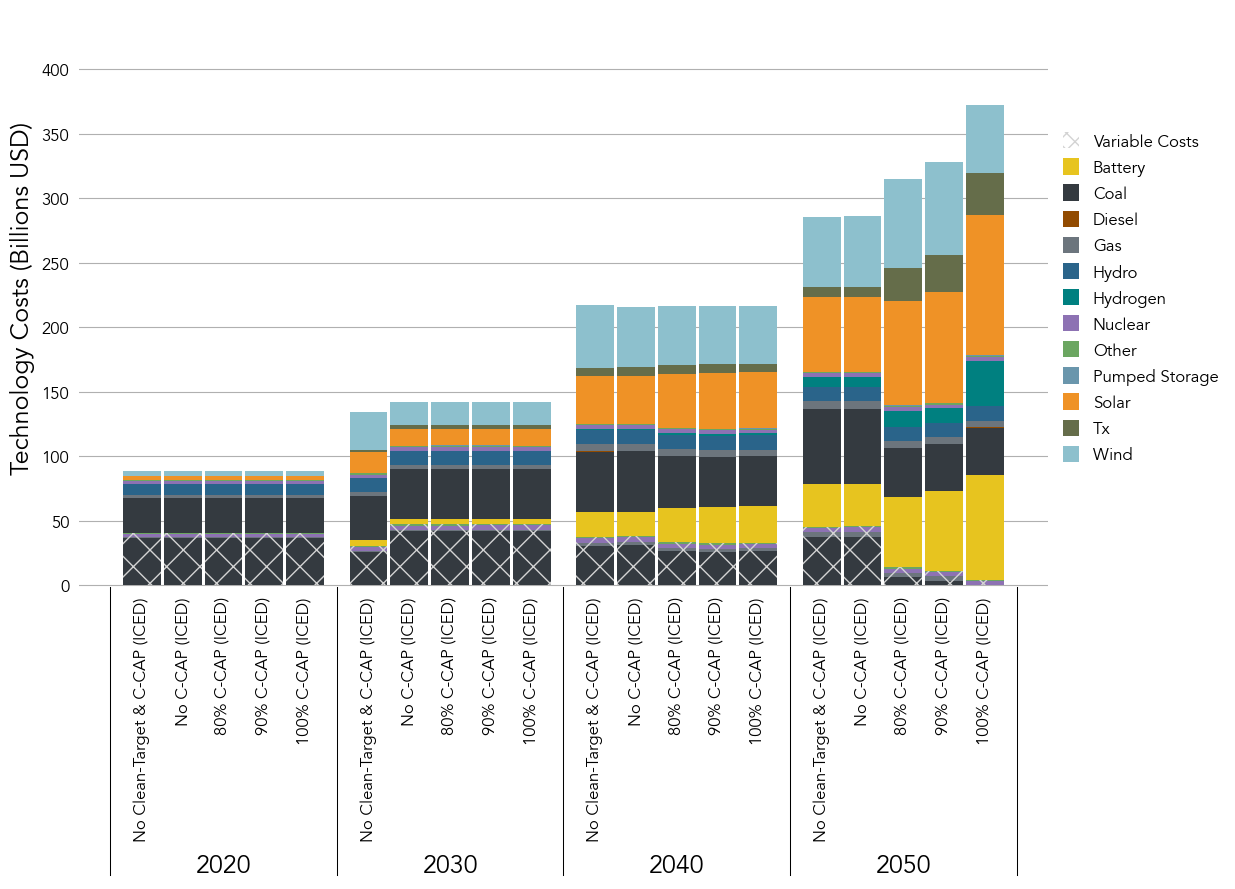

In [7]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_,
                                    scen_labels_, tech_labels_, 
                                    units_label  = r'Technology Costs (Billions USD)')

plt.savefig(path_to_images + r'/fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()

### Levelized Technology Costs

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid


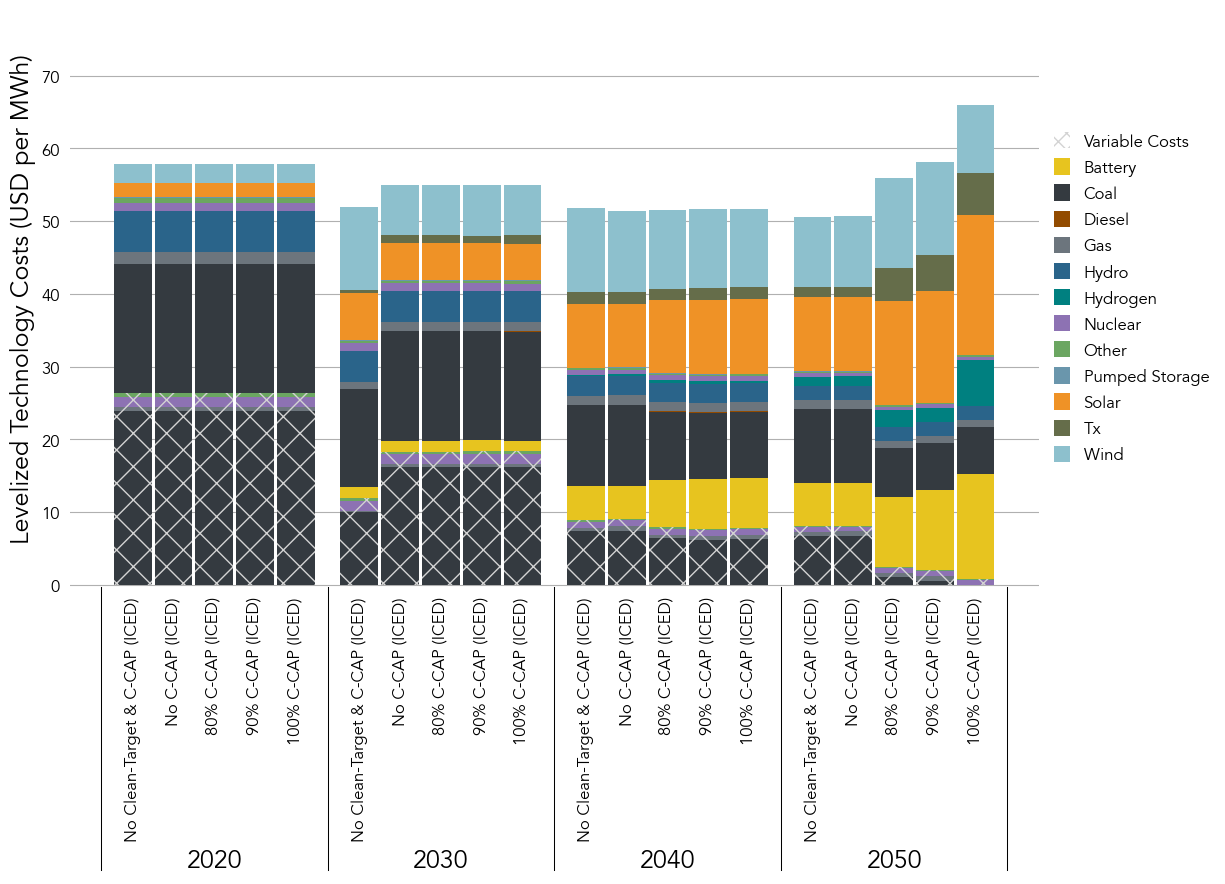

In [8]:
fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax, grouped_tech_cost_by_tech_, total_demand_,
                                        scen_labels_, tech_labels_, 
                                        units_label = r'Levelized Technology Costs (USD per MWh)')

plt.savefig(path_to_images + r'/levelized_fixed_and_variable_costs.png', 
            bbox_inches = 'tight',
            dpi         = 600)

plt.show()

# Mosaic

In [ ]:
tech_cost_, demand_                       = _load_cost(scen_labels_)
grouped_tech_cost_                        = _group_cost_technologies(tech_cost_, tech_labels_)
grouped_tech_cost_by_tech_, total_demand_ = _group_tech_cost_by_tech(grouped_tech_cost_, demand_, scen_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_ICEDmid


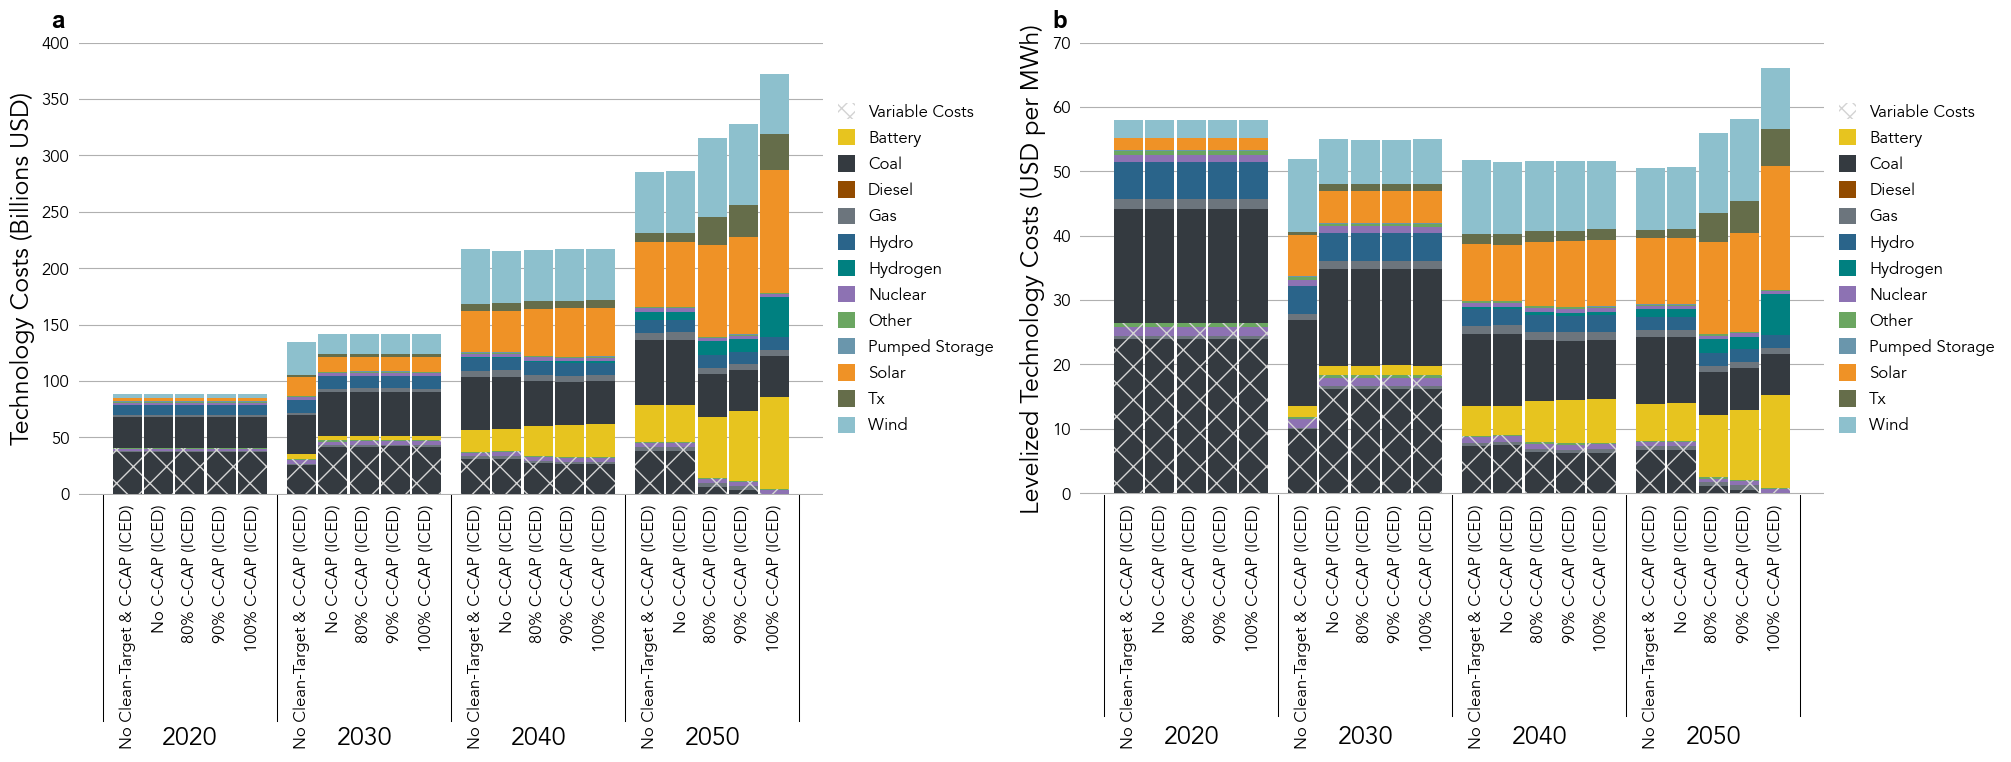

In [13]:
fig, _ax = plt.subplot_mosaic([['a', 'b']], layout      = 'constrained', 
                                            figsize     = (20, 7.5), 
                                            gridspec_kw = {'width_ratios': [1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_total_fixed_and_variable_cost(_ax['a'], grouped_tech_cost_by_tech_,
                                    scen_labels_, tech_labels_, 
                                    units_label  = r'Technology Costs (Billions USD)')
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_levelized_fixed_and_variable_cost(_ax['b'], grouped_tech_cost_by_tech_, total_demand_,
                                        scen_labels_, tech_labels_, 
                                        units_label = r'Levelized Technology Costs (USD per MWh)')

plt.savefig(path_to_images + '/tech_cots-bar_plots.png', bbox_inches = 'tight', 
                                                         dpi         = 300)

plt.show()